In [410]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [411]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.transforms import ToTensor, Compose, Normalize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import ImageDataset, DSubset, Label, get_channel_means_stdevs

import pickle

In [412]:
labels_map = {1: 'Airplane', 2: 'Automobile', 3: 'Bird', 4: 'Cat', 5: 'Deer', 6: 'Dog', 7: 'Frog', 8: 'Horse', 9: 'Ship', 10: 'Truck'}

with open('../results/channel_training_statistics.pkl', 'rb') as f:
    training_channel_means, training_channel_stdevs = pickle.load(f)
    
tf = Compose([
    Normalize(training_channel_means, training_channel_stdevs)
])

label_type = Label.REAL_OR_SYNTHETIC

train_dataset = ImageDataset(DSubset.TRAIN, label_type, transform = tf)
test_dataset = ImageDataset(DSubset.TEST, label_type, transform = tf)

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [479]:
# num_channels = 3
# train_channel_means, train_channel_stdevs = get_channel_means_stdevs(train_dataloader, num_channels = num_channels, verbose = False)

# # Verify successful standardization functionality: mean 0 and standard deviation 1 on training set
# assert np.allclose(np.array(train_channel_means), np.zeros(num_channels), atol = 1e-5)
# assert np.allclose(np.array(train_channel_stdevs), np.ones(num_channels), atol = 1e-5)

In [414]:
class SyntheticCNN(nn.Module):
    """
    Convolutional Neural Network to classify images of being either real 
    or synthetically (AI) generated.
    """
    def __init__(self):
        """
        SyntheticCNN initializer.
        """
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, 5), # [BATCH_SIZE, 3, 32, 32] -> [BATCH_SIZE, 8, 28, 28]
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # [BATCH_SIZE, 8, 28, 28] -> [BATCH_SIZE, 8, 14, 14]
            nn.Conv2d(8, 20, 5), # [BATCH_SIZE, 8, 14, 14] -> [BATCH_SIZE, 20, 10, 10]
            nn.BatchNorm2d(20),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # [BATCH_SIZE, 20, 10, 10] -> [BATCH_SIZE, 20, 5, 5]
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(20 * 5 * 5, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LayerNorm(16),
            nn.LeakyReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        """
        SyntheticCNN forward method. Runs convolutional layers first, then
        converts to linear layers.

        Args:
            x -- The input to be passed through the network.

        Returns:
            x -- The output of the model.
        """
        x = self.conv_layers(x)
        x = torch.flatten(x, start_dim = 1) # Flatten all dimensions except batch (dim 0)
        x = self.linear_layers(x)

        return x # logit of class 1 (synthetic) likelihood
    
synthetic_model = SyntheticCNN()

In [415]:
binary_cross_entropy = nn.BCEWithLogitsLoss()

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
MOMENTUM = 0.9

sgd = torch.optim.SGD(synthetic_model.parameters(), lr = LEARNING_RATE, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY)
# adamw = torch.optim.AdamW(synthetic_model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

In [416]:
def run_train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, optimizer: torch.optim.Optimizer):
    """
    Runs one full epoch of training on model.

    Args:
        dataloader -- The DataLoader through which to produce instances.
        model -- The model to be used for label prediction on instances.
        loss_fn -- The loss function, for backpropagation
        optimizer -- The optimizer, for reducing loss

    Returns:
        average_epoch_loss -- The model loss this epoch, averaged by the number of instances in the dataset
        epoch_accuracy -- The model accuracy this epoch, averaged by the number of instances in the dataset
    """
    model.train()

    num_correct_total = 0
    epoch_loss = 0.0

    for i, (X, y) in enumerate(dataloader):

        pred = model(X)
        batch_loss = loss_fn(pred.squeeze(), y.float())

        batch_loss.backward()
        
        epoch_loss += batch_loss.item()

        num_correct_in_batch = torch.sum((torch.sigmoid(pred.detach().squeeze()) > 0.5).float() == y.float()).item()
        num_correct_total += num_correct_in_batch

        # print(f'Batch {i+1} | Loss: {batch_loss.item():>7f} | Accuracy: {num_correct_in_batch / len(y):>7}')

        optimizer.step()
        optimizer.zero_grad()

    average_epoch_loss = epoch_loss / len(dataloader.dataset)
    epoch_accuracy = num_correct_total / len(dataloader.dataset)

    return average_epoch_loss, epoch_accuracy


def run_test_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module):
    """
    Runs one full dataset-worth of testing on model.

    Args:
        dataloader -- The DataLoader through which to produce instances.
        model -- The model to be used for label prediction on instances.
        loss_fn -- The loss function, for improvement checking

    Returns:
        average_epoch_loss -- The model loss this epoch, averaged by the number of instances in the dataset
        epoch_accuracy -- The model accuracy this epoch, averaged by the number of instances in the dataset
    """
    model.eval()

    num_correct = 0
    epoch_loss = 0.0

    with torch.no_grad():

        for X, y in dataloader:

            pred = model(X)
            batch_loss = loss_fn(pred.squeeze(), y.float())

            epoch_loss += batch_loss.item()
            num_correct += torch.sum((torch.sigmoid(pred.detach().squeeze()) > 0.5).float() == y.float()).item()

    average_epoch_loss = epoch_loss / len(dataloader.dataset)
    epoch_accuracy = num_correct / len(dataloader.dataset)

    return average_epoch_loss, epoch_accuracy

In [418]:
EPOCHS = 10

for i in range(EPOCHS):
    train_loss, train_accuracy, = run_train_loop(train_dataloader, synthetic_model, binary_cross_entropy, sgd)
    test_loss, test_accuracy = run_test_loop(test_dataloader, synthetic_model, binary_cross_entropy)

    print(f'Epoch {i+1:>2} | Train Loss: {train_loss:>9f} | Train Accuracy: {train_accuracy:>9f}')
    print(f'Epoch {i+1:>2} | Test Loss: {test_loss:>10f} | Test Accuracy: {test_accuracy:>10f}')
    print('-' * len(f'Epoch {i+1} | Train Loss: {train_loss:>10f} | Train Accuracy: {train_accuracy:>10f}'))

Epoch  1 | Train Loss:  0.003600 | Train Accuracy:  0.908090
Epoch  1 | Test Loss:   0.003628 | Test Accuracy:   0.907050
-------------------------------------------------------------
Epoch  2 | Train Loss:  0.003280 | Train Accuracy:  0.917330
Epoch  2 | Test Loss:   0.003091 | Test Accuracy:   0.921950
-------------------------------------------------------------
Epoch  3 | Train Loss:  0.003118 | Train Accuracy:  0.922050
Epoch  3 | Test Loss:   0.003029 | Test Accuracy:   0.923650
-------------------------------------------------------------
Epoch  4 | Train Loss:  0.002946 | Train Accuracy:  0.927310
Epoch  4 | Test Loss:   0.002896 | Test Accuracy:   0.927550
-------------------------------------------------------------
Epoch  5 | Train Loss:  0.002847 | Train Accuracy:  0.928630
Epoch  5 | Test Loss:   0.003050 | Test Accuracy:   0.923950
-------------------------------------------------------------
Epoch  6 | Train Loss:  0.002711 | Train Accuracy:  0.932420
Epoch  6 | Test Los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5959820959542412e-09..0.9019607909045959].


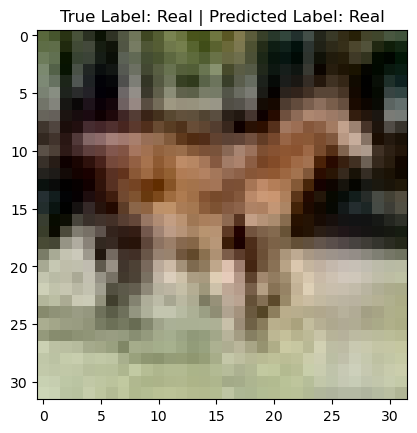

In [500]:
synthetic_model.eval()

X, y = next(iter(test_dataloader))

img = X[0].detach()
np_img = (img.numpy().transpose(1, 2, 0) * training_channel_stdevs) + training_channel_means

label = y[0]
pred = (torch.sigmoid(synthetic_model(img.unsqueeze(0))) > 0.5).float().item()
plt.imshow(np_img, cmap = 'rainbow')
plt.title(f'True Label: {"Synthetic" if label else "Real"} | Predicted Label: {"Synthetic" if pred else "Real"}')
plt.show()